In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
import itertools
import tqdm

## Lookat function along with some utilities

In [2]:
def lookat(origin, loc):
    dir = loc - origin
    dir = dir/np.linalg.norm(dir)

    tmp = np.array([0, 0, 1]) 
    right = np.cross(tmp, dir) 
    up = np.cross(dir, right)
    # up = -np.cross(tmp, dir) 
    # right = -np.cross(dir, up)

    R = np.hstack([right[..., None], up[..., None], dir[..., None]])

    return np.vstack([np.hstack([R, loc[..., None]]), np.asarray([0, 0, 0, 1])[None, ...]])

def circle_points(z, radius, num_points):
    split = torch.FloatTensor([(2 * torch.pi) / num_points])

    vals = []
    for i in range(num_points):
        angle = split * i
        vals.append(torch.FloatTensor(
            [radius * torch.cos(angle), radius * torch.sin(angle), z]))
    return vals

def pose_to_rays(rotation, translation, focal, h, w, t_n, t_f, num_samples):
    xs = torch.arange(w)
    ys = torch.arange(h)

    h_mesh, w_mesh = torch.meshgrid(xs, ys, indexing='ij')

    pixels_unflatten = torch.stack([(w_mesh - w * .5) / focal, -(
        h_mesh - h * .5) / focal, -torch.ones_like(h_mesh)], dim=-1)
    pixels = torch.reshape(pixels_unflatten, (h*w, 3))

    dirs = torch.matmul(rotation, pixels.T).T
    dirs_tformed = torch.reshape(dirs, (h, w, 3))

    origin = torch.broadcast_to(translation, dirs_tformed.shape)

    ts = torch.linspace(t_n, t_f, steps=num_samples)

    ray_points = origin[..., None, :] + \
        dirs_tformed[..., None, :] * ts[:, None]

    return ray_points.numpy()

In [3]:
poses = []

vals = circle_points(2, 5, 50)

for i, position in tqdm.tqdm(enumerate(vals)):
    c2w = lookat(torch.FloatTensor([0, 0, 0]), torch.Tensor(position)).astype(np.float32)
    R, t = c2w[:3, :3], np.squeeze(c2w[:3, 3:])
    poses.append((R, t))
    

50it [00:00, 1397.68it/s]


### Plotting Middle ray for evenly-sized images

In [4]:
def plot_dataset(poses):

    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')

    for pose in poses:
        R, t = pose
        rays = pose_to_rays(torch.tensor(R), torch.tensor(t), 1, 10, 10, 2, 6, 100)

        rays = rays[5, 5, :, :]
        x, y, z = rays[..., 0], rays[..., 1], rays[..., 2]

        x, y, z = np.reshape(x, -1), np.reshape(y, -1), np.reshape(z, -1)

        ax.scatter(x,y,z)
        x_o, y_o, z_o = list(t)
        ax.scatter(x_o, y_o, z_o, color='green')

    plt.show()

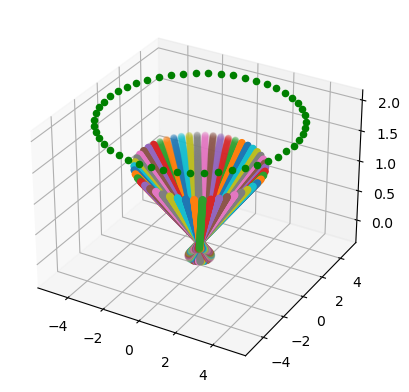

In [126]:
plot_dataset(poses)